In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2, glob, math
from collections import deque
%matplotlib inline

## Camera Calibration and Distortion removal

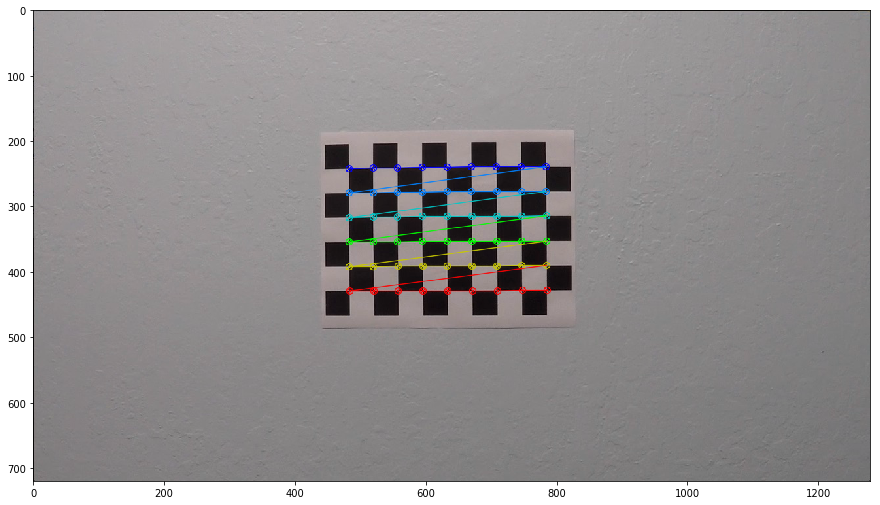

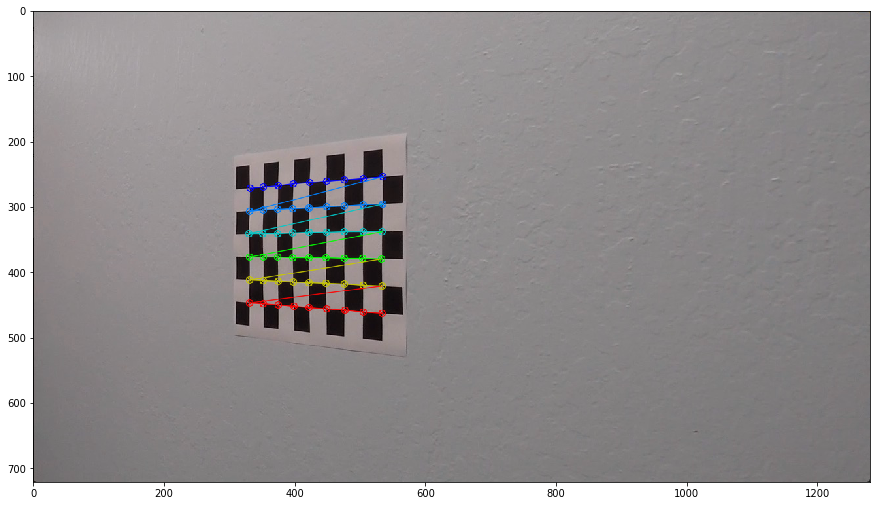

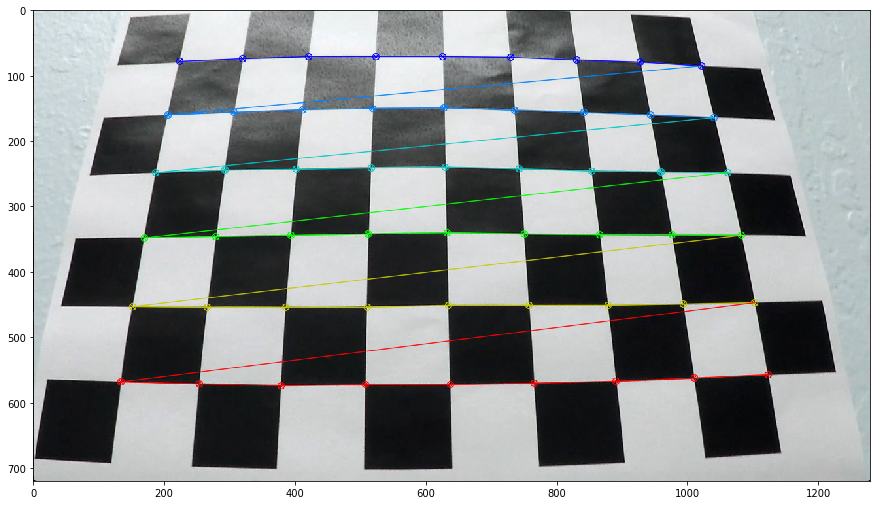

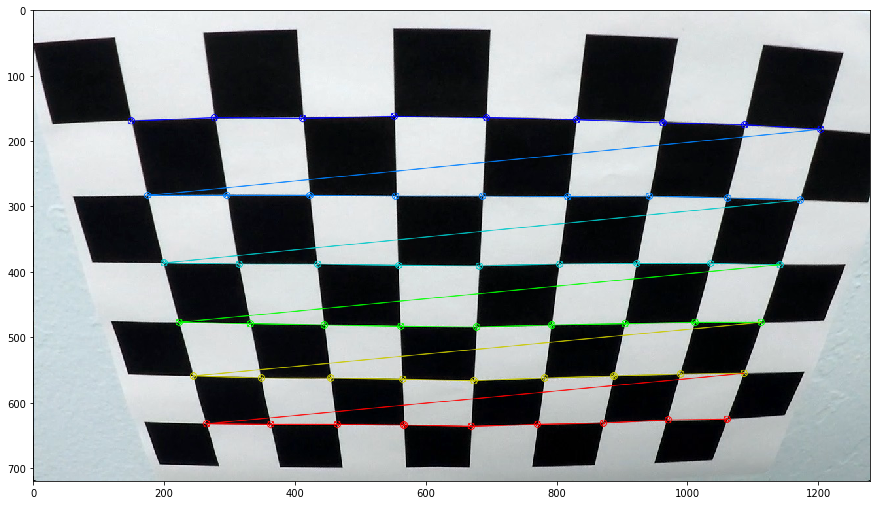

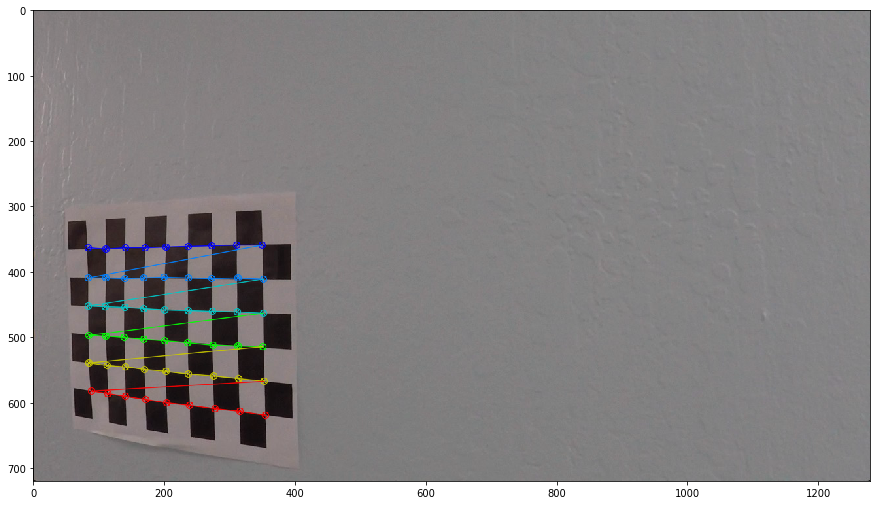

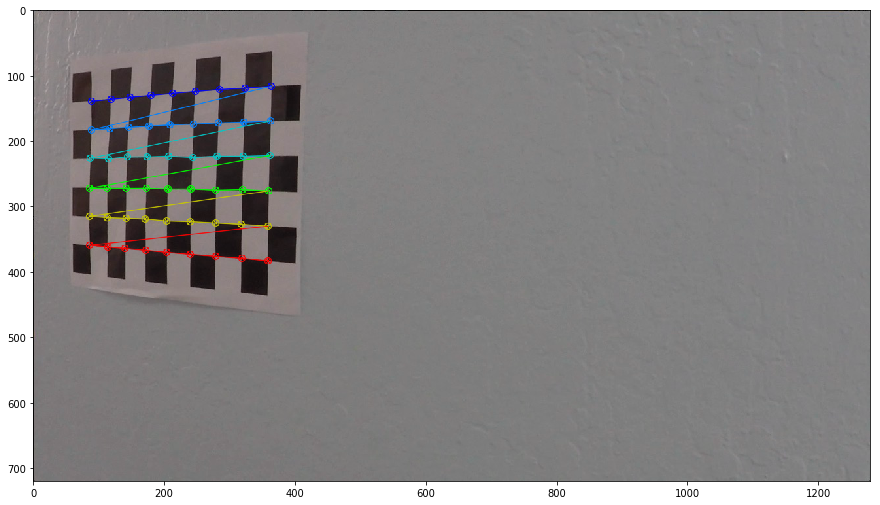

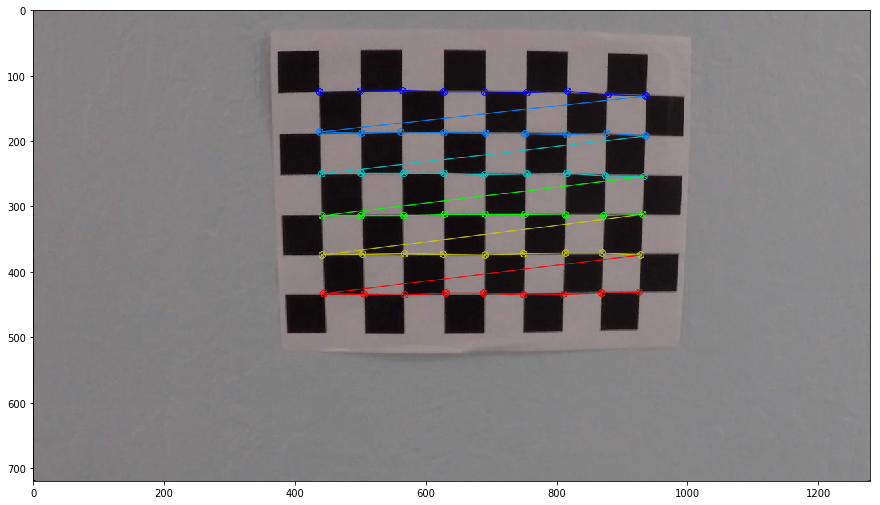

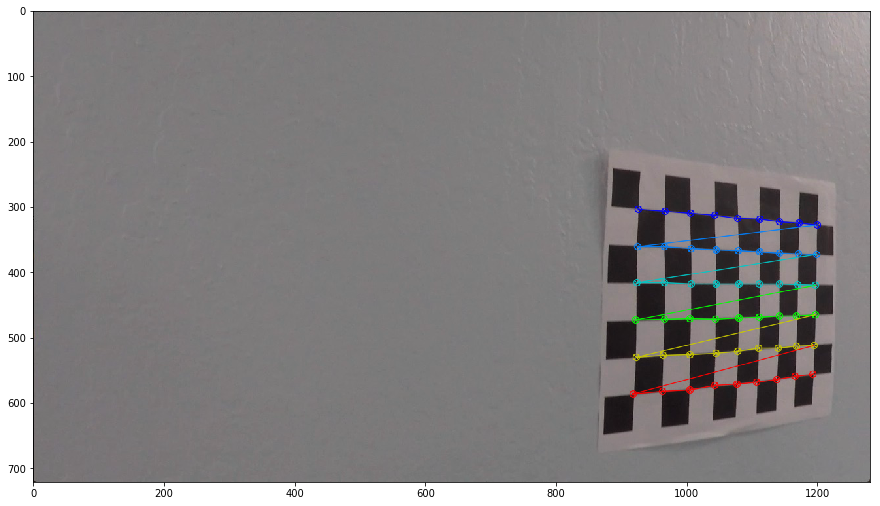

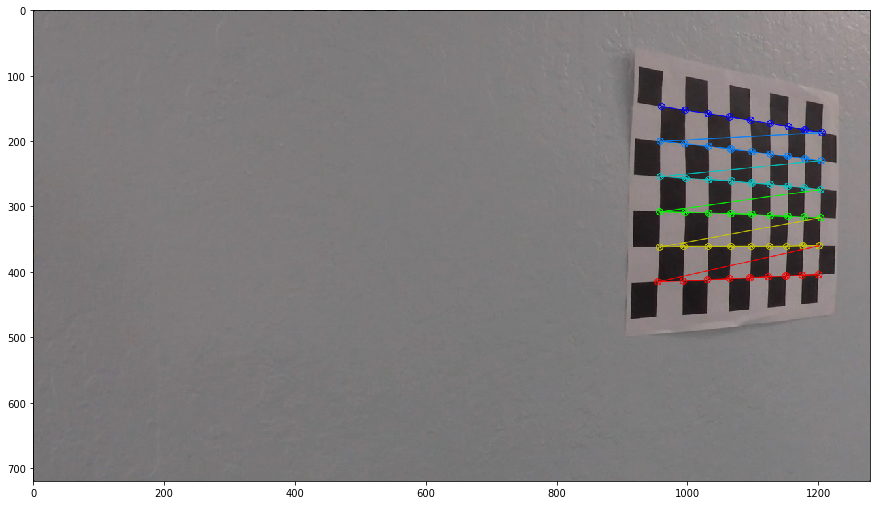

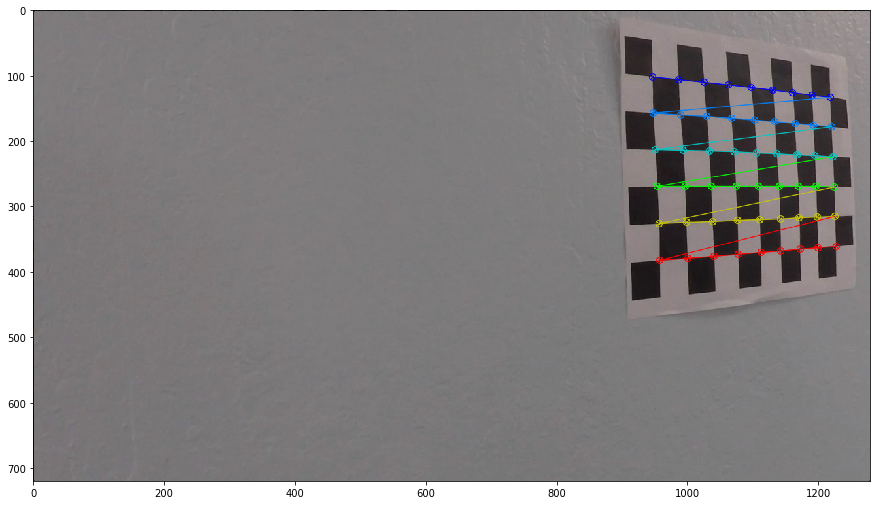

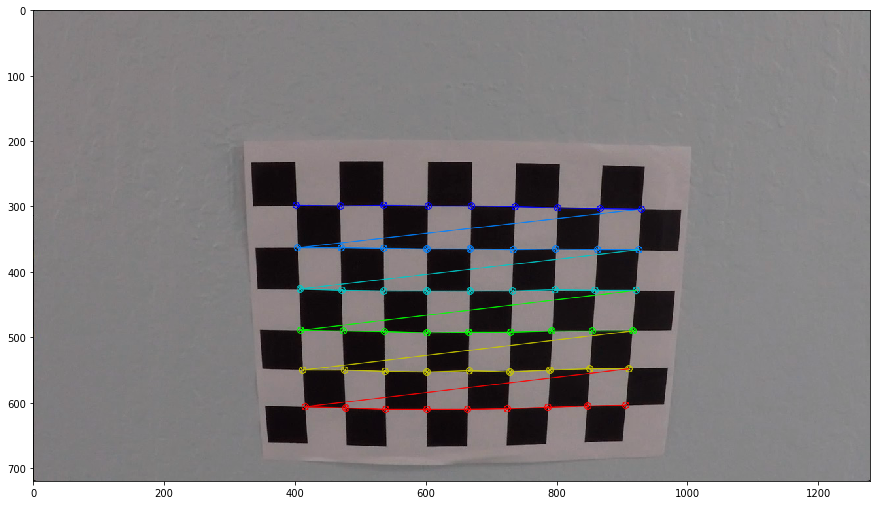

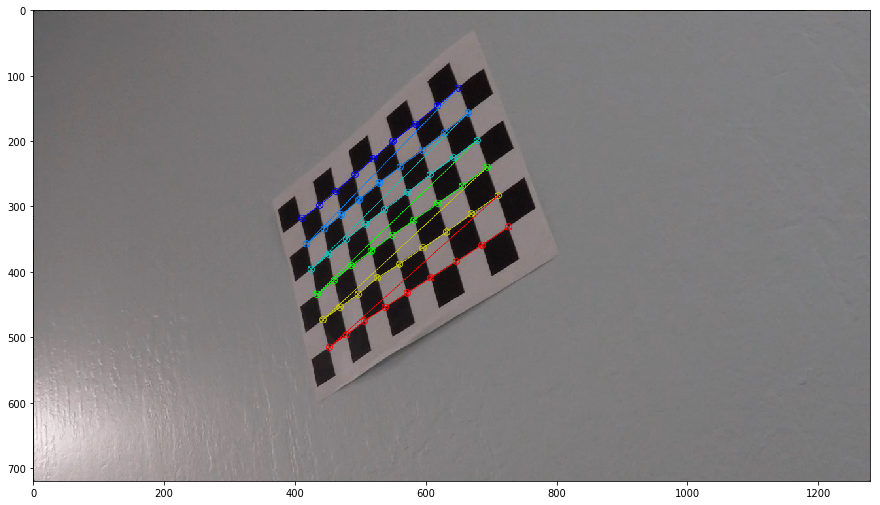

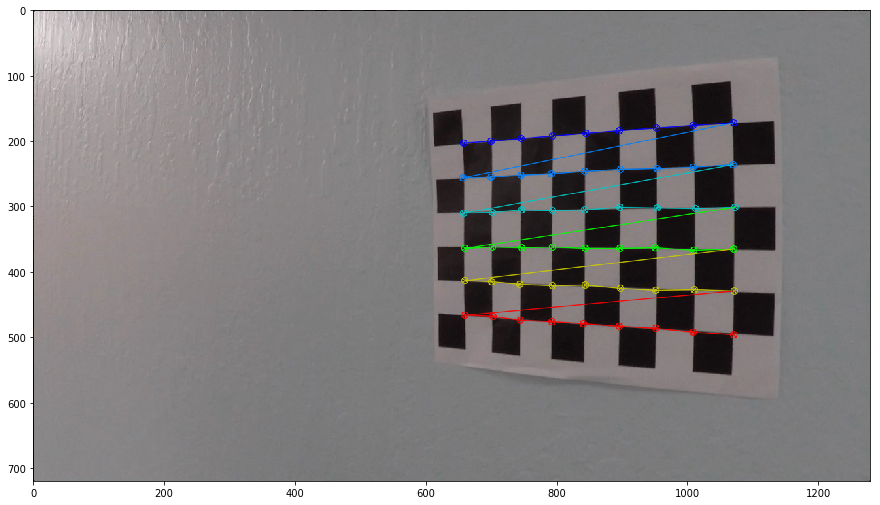

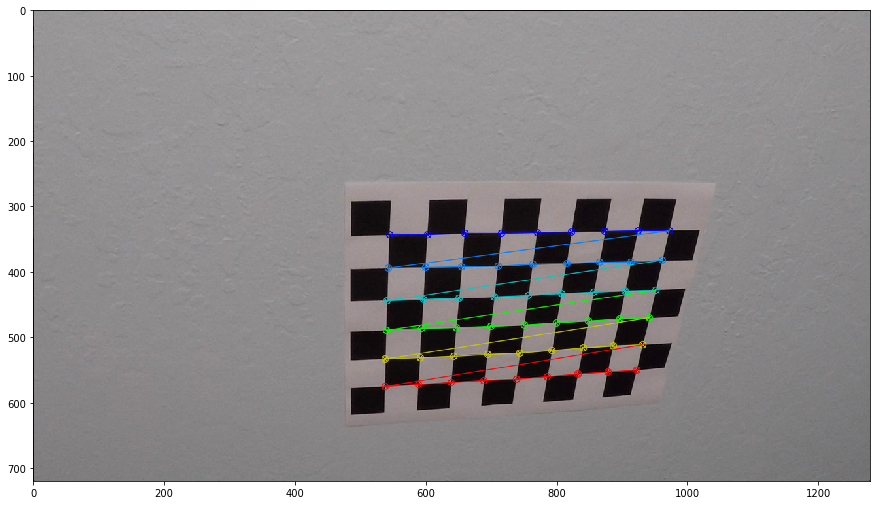

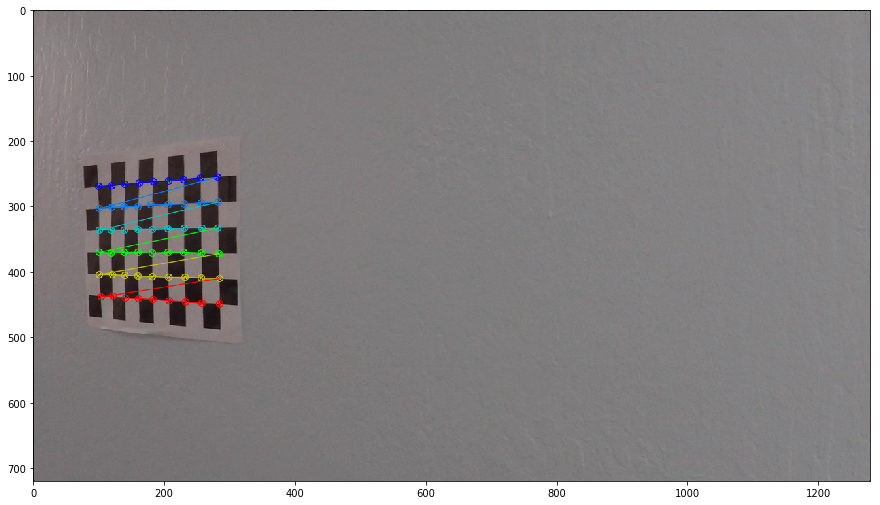

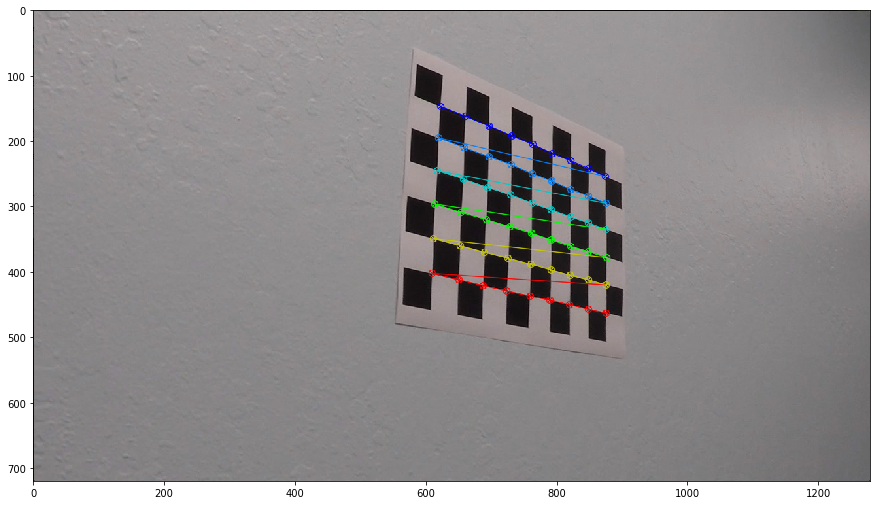

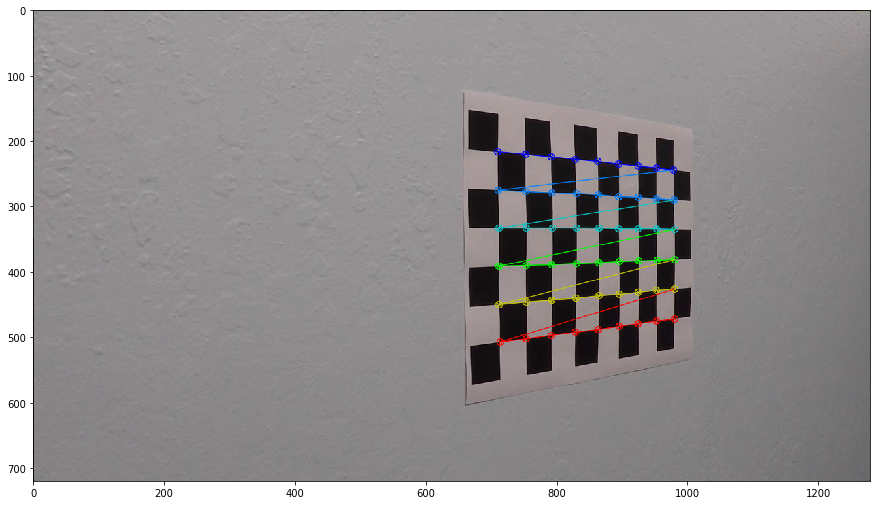

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
cols = 2
rows = math.ceil(len(images)/cols)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure(figsize=(15,9))
        plt.imshow(img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [3]:
img = cv2.cvtColor(cv2.imread("camera_cal/calibration1.jpg"), cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])
def calibrate():
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist
mtx, dist = calibrate()

In [4]:
def undistort_image(img, mtx, dist):
    dist = cv2.undistort(img, mtx, dist, None, mtx)
    return dist

## Perspective Transform

In [ ]:
def warp(img):
    # set the source and destination points
    src = np.float32([[(180,720), (560,460), (740,460), (1200,720)]])
    dest = np.float32([[(100,720), (0,0), (1300,0), (1200,720)]])
    
    # get the transformed image
    M = cv2.getPerspectiveTransform(src, dest)
    
    # get the transformed image
    MInv = cv2.getPerspectiveTransform(dest, src)
    
    # warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # return the warped image
    return warped, MInv

## Color Spaces and Gradients

In [ ]:
def binarize(b, thresh=(210, 255)):
    binary = np.zeros_like(b)
    binary[(b >= thresh[0]) & (b <= thresh[1])] = 1
    return binary

In [ ]:
def combine_thresholds(binary_1, binary_2):
    combined_binary = np.zeros_like(binary_1)
    combined_binary[(binary_1 == 1) | (binary_2 == 1)] = 1
    return combined_binary

In [ ]:
def threshold_image(img, s_thresh, v_thresh):
    
    # get the s channel from HLS
    s = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    # get the v channel from HSV
    v = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    
    # binarize both s and v
    s_b = binarize(s, s_thresh)
    v_b = binarize(v, v_thresh)
    
    # combine the channels
    combined = combine_thresholds(s_b, v_b)
    
    # return the combined image
    return combined

In [ ]:
def pipeline(img):
    
    # set thresholds
    s_thresh, v_thresh = (200,240), (230,255)
    
    # undistort the image
    undist_img = undistort_image(img, mtx, dist)
    
    # warp the image
    warped, MInv = warp(undist_img)
    
    # seperately binarize the image and apply thresholds
    binary_warped = threshold_image(warped, s_thresh, v_thresh)
    
    return binary_warped, MInv

In [ ]:
from moviepy.editor import VideoFileClip

## Fitting the lines

In [ ]:
class Line():
    def __init__(self):
        
        ## provided
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        left_fit = np.array([ -8.05644798e-05,   2.72836853e-02,   1.49040374e+02])
        right_fit = np.array([  8.65563029e-06,   1.06080737e-01,   1.01501522e+03])
        self.best_fit = [left_fit, right_fit]  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        ## custom
        self.max_undetected_lines_allowed = 5
        self.lines_undetected_cnt = 0
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.nwindows = 10
        self.margin = 70
        self.minpix = 20

    def search_when_not_detected(self, binary_warped):

        nwindows = self.nwindows
        margin = self.margin
        minpix = self.minpix
        
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        window_height = np.int(binary_warped.shape[0]//nwindows)

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []
        
        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        self.detected = True
        self.lines_undetected_cnt = 0

        return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds


    def search_when_detected(self, binary_warped):

        margin = self.margin
        left_fit, right_fit = self.best_fit
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds
    
    def update_fit(self, left_fit, right_fit, thresh=4):

        self.current_fit = [left_fit, right_fit]
        self.recent_xfitted.append(self.current_fit)

        if len(self.recent_xfitted) > thresh:
            self.recent_xfitted.pop(0)

        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        
        return self.best_fit
        
    def fit_poly(self, binary_warped, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds):

        margin = self.margin
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.int8)
        window_img = np.zeros_like(out_img)
        windom_img = np.zeros_like(out_img)
        
        try:
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            left_fit, right_fit = self.update_fit(left_fit, right_fit)

            img_size = binary_warped.shape
            del_left = 2 * left_fit[0] * img_size[0]/2.0 + left_fit[1]
            del_right = 2 * right_fit[0] * img_size[0]/2.0 + right_fit[1]

            if abs(del_left - del_right) < 1.0:
                self.lines_undetected_cnt = 0
            else:
                self.lines_undetected_cnt += 1

        except TypeError:

            left_fit, right_fit = self.best_fit

            self.lines_undetected_cnt += 1

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

        self.ploty = ploty

        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]

        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        y_eval = np.max(ploty)

        left_fit_cr = np.polyfit(ploty*self.ym_per_pix, left_fitx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*self.ym_per_pix, right_fitx*self.xm_per_pix, 2)

        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        result = cv2.addWeighted(out_img, 1, window_img, 0.2, 0)        

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(result, np.int_([pts]), (0,255, 0))

        return result, left_curverad, right_curverad

    def find_lines(self, binary_warped):
        
        if not self.detected or lines_undetected_cnt >= max_undetected_lines_allowed:
            leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = self.search_when_detected(binary_warped)
        else:
            leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = self.search_when_not_detected(binary_warped)
            
        return self.fit_poly(binary_warped, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds)
        
def display_on_frame(image, left_curverad, right_curverad, car_off):
    font = cv2.FONT_HERSHEY_COMPLEX
    curve_disp_txt = 'Curvature: Right = ' + str(np.round(right_curverad,2)) + 'm, Left = ' + str(np.round(left_curverad,2)) + 'm' 
    off_disp_txt = 'Car off by ' + str(np.round(car_off,2)) + 'm'
    cv2.putText(image, curve_disp_txt, (30, 60), font, 1, (0,0,0), 2)
    cv2.putText(image, off_disp_txt, (30, 110), font, 1, (0,0,0), 2)
    return image

In [ ]:
line = Line()
def proc_video(img):
    
    original_frame = np.copy(img)
    
    # run the image pipeline
    binary, MInv = pipeline(img)
    
    # draw the lines on the binary image
    frame, left_curverad, right_curverad = line.find_lines(binary)
    img_size = (frame.shape[:2][0], frame.shape[:2][1])
    
    # unwarp the image
    unwarped = np.uint8(cv2.warpPerspective(frame, MInv, img_size, flags=cv2.INTER_LINEAR))
    
    # combine with the original image
    result = cv2.addWeighted(original_frame, 1, unwarped, 0.3, 0)
    
    # 
    left_fit, right_fit = line.best_fit
    left_intcpt = left_fit[0]*img_size[0]**2 + left_fit[1]*img_size[0] + left_fit[2]
    right_intcpt = right_fit[0]*img_size[0]**2 + right_fit[1]*img_size[0] + right_fit[2]
    
    lane_width = abs(right_intcpt-left_intcpt)
    lane_mid = (left_intcpt + right_intcpt)/2
    
    car_off = (lane_mid - img_size[1]/2.0)*self.xm_per_pix
    
    result = display_on_frame(result, left_curverad=left_curverad, 
                                  right_curverad=right_curverad, car_off=car_off)
    
    # return the combined original result
    return result

In [ ]:
vid_output ='project_video_output.mp4'
clip_source = VideoFileClip('project_video.mp4')
vid_clip = clip_source.fl_image(proc_video) #NOTE: this function expects color images!!
vid_clip.write_videofile(vid_output, audio=False)